In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from collections import defaultdict

# --- Configuration ---
INPUT_FILENAME = "results_15102025.txt"
OUTPUT_PLOT_FILENAME = "performance_plot.png"

In [27]:
def parse_results_file(filename):
    """
    Parses the experiment results file line by line to extract data.
    """
    parsed_data = []
    checksums = defaultdict(set)
    
    # Regex to capture all key fields
    # 1. algorithm: (dijkstra|bmssp)
    # 2. graph_path: .*?/graphs/(.*)
    # 3. source/reps: source: \d+ reps: \d+
    pattern_alg_graph = re.compile(r"^(dijkstra|bmssp) on .*?/graphs/(.+?\.gr) source: \d+ reps: \d+$")
    pattern_time = re.compile(r"^time: (\d+\.?\d*) ms$")
    pattern_std = re.compile(r"^std: (\d+\.?\d*) ms$")
    pattern_checksum = re.compile(r"^checksum: (\d+)$")

    current_entry = {}
    
    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                
                # Check for Algorithm/Graph line (Start of a new block)
                match_alg_graph = pattern_alg_graph.match(line)
                if match_alg_graph:
                    # If an entry was partially filled, store it if possible, or skip
                    if current_entry and 'time' in current_entry and 'checksum' in current_entry:
                        parsed_data.append(current_entry)
                    
                    # Start new entry
                    algorithm = match_alg_graph.group(1)
                    graph_file = match_alg_graph.group(2)
                    
                    # Extract graph size (N) from filename, e.g., 'random100D5.gr' -> 100
                    graph_size_match = re.search(r'random(\d+)', graph_file)
                    graph_size = int(graph_size_match.group(1)) if graph_size_match else -1
                    
                    current_entry = {
                        'algorithm': algorithm,
                        'graph_file': graph_file,
                        'graph_size': graph_size,
                        # Set defaults for optional/next lines
                        'time': None,
                        'std': 0.0, 
                        'checksum': None
                    }
                    continue

                # Check for Time line
                match_time = pattern_time.match(line)
                if match_time and current_entry:
                    current_entry['time'] = float(match_time.group(1))
                    continue
                    
                # Check for StdDev line
                match_std = pattern_std.match(line)
                if match_std and current_entry:
                    current_entry['std'] = float(match_std.group(1))
                    continue
                
                # Check for Checksum line (End of a block)
                match_checksum = pattern_checksum.match(line)
                if match_checksum and current_entry:
                    current_entry['checksum'] = match_checksum.group(1)
                    
                    # Store the complete entry and update checksums dictionary
                    if current_entry['time'] is not None:
                        parsed_data.append(current_entry)
                        # The key for checksum validation should be the unique graph path/size
                        checksums[current_entry['graph_file']].add(current_entry['checksum'])
                    
                    # Reset current_entry for the next block (important for line-based logic)
                    current_entry = {}
                    continue
                    
    except FileNotFoundError:
        print(f"ERROR: Input file '{filename}' not found.")
        return None, None
    
    return parsed_data, checksums

In [28]:
def validate_checksums(checksums):
    """
    Checks if all runs on the same graph have the same checksum.
    """
    is_valid = True
    print("\n--- Checksum Validation ---")
    for graph_file, cs_set in checksums.items():
        if len(cs_set) > 1:
            print(f"❌ MISMATCH found for graph: {graph_file}")
            print(f"   Observed Checksums: {cs_set}")
            is_valid = False
        else:
            print(f"✅ OK: {graph_file} (Checksum: {cs_set.pop()})")
    
    if is_valid:
        print("\nAll runs for the same graph produced a matching checksum.")
    else:
        print("\nACTION REQUIRED: Checksum mismatch detected. Results may be inconsistent.")
        
    return is_valid

In [ ]:
def create_and_save_time_plot(df, filename):
    """
    Generates and saves the performance plot with error bars.
    """
    print("\n--- Generating Execution Time Plot ---")
    try:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Group by algorithm and iterate to plot two separate lines
        for algo, group in df.groupby('algorithm'):
            # The 'time' column is the mean time, 'std' is the standard deviation
            ax.errorbar(
                group['graph_size'], 
                group['time'], 
                yerr=group['std'], 
                fmt='-o', 
                capsize=5, 
                label=algo
            )

        # Set plot properties
        ax.set_xscale('log') # Graph size often spans orders of magnitude
        ax.set_xlabel('Graph Size (Number of Vertices)')
        ax.set_yscale('log')
        ax.set_ylabel('Execution Time (ms)')
        ax.set_title('Algorithm Performance vs. Graph Size')
        ax.legend(title='Algorithm')
        ax.grid(True, which="both", ls="--", linewidth=0.5)

        # Ensure x-axis labels are readable
        ax.set_xticks(df['graph_size'].unique())
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

        plt.tight_layout()
        plt.savefig("time_" + filename) # Save with a prefix for clarity
        print(f"Time plot saved successfully to: time_{filename}")

    except Exception as e:
        print(f"ERROR during time plot generation: {e}")

def create_and_save_ratio_plot(df_ratio, filename):
    """
    Generates and saves a plot of the ratio of bmssp time to dijkstra time.
    """
    print("\n--- Generating Ratio Plot ---")
    try:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the ratio
        ax.plot(
            df_ratio['graph_size'],
            df_ratio['ratio'],
            marker='o',
            linestyle='-',
            color='r',
            label='BMSPP Time / Dijkstra Time'
        )

        # Add a horizontal line at 1.0 for reference
        ax.axhline(1.0, color='gray', linestyle='--', linewidth=0.8, label='Ratio = 1.0 (Break-Even)')

        # Set plot properties
        ax.set_xscale('log') # Keep log scale for graph size
        ax.set_xlabel('Graph Size (Number of Vertices)')
        ax.set_ylabel('Performance Ratio (BMSPP Time / Dijkstra Time)')
        ax.set_title('BMSPP vs. Dijkstra Performance Ratio')
        ax.legend()
        ax.grid(True, which="both", ls="--", linewidth=0.5)

        # Ensure x-axis labels are readable
        ax.set_xticks(df_ratio['graph_size'].unique())
        ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

        plt.tight_layout()
        ratio_filename = "ratio_" + filename # New filename to avoid overwriting
        plt.savefig(ratio_filename)
        print(f"Ratio plot saved successfully to: {ratio_filename}")

    except Exception as e:
        print(f"ERROR during ratio plot generation: {e}")


--- Checksum Validation ---
✅ OK: random100D5.gr (Checksum: 922337207998282941)
✅ OK: random1000D5.gr (Checksum: 922337229675622406)
✅ OK: random10000D5.gr (Checksum: 922337634357326494)
✅ OK: random100000D5.gr (Checksum: 922341670265042300)
✅ OK: random1000000D5.gr (Checksum: 922381009653380493)
✅ OK: random10000000D5.gr (Checksum: 922774531521826376)
✅ OK: random20000000D5.gr (Checksum: 923214879147080272)
✅ OK: random30000000D5.gr (Checksum: 923652287364027240)

All runs for the same graph produced a matching checksum.

--- Generating Execution Time Plot ---
Time plot saved successfully to: time_performance_plot.png

--- Generating Ratio Plot ---
Ratio plot saved successfully to: ratio_performance_plot.png


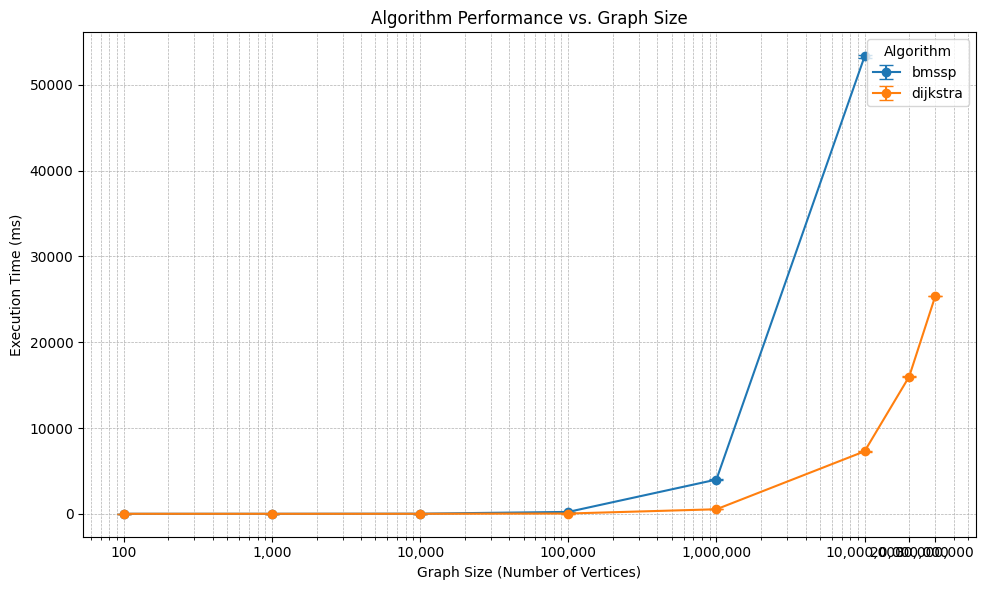

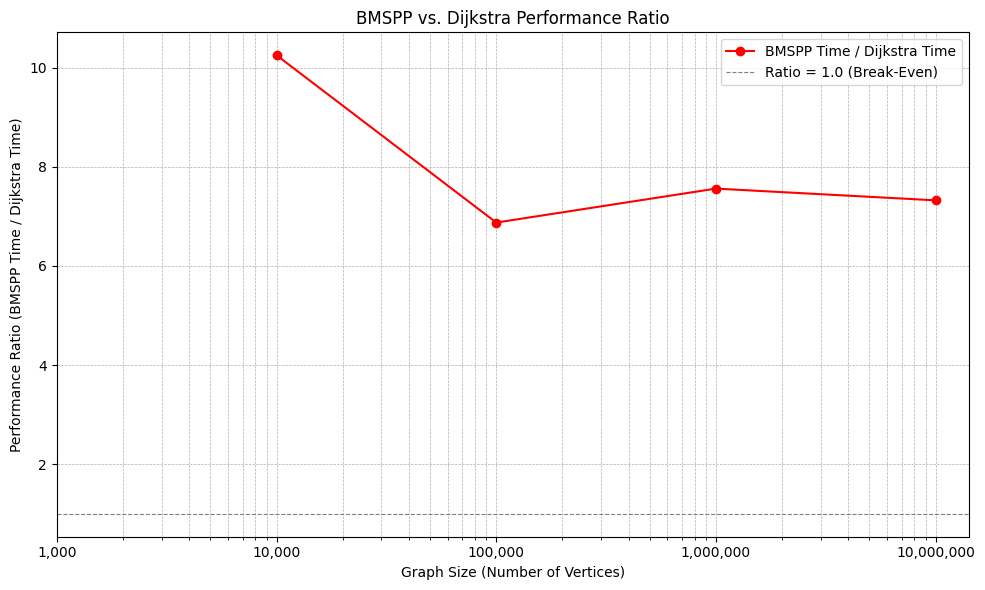

In [30]:
if __name__ == "__main__":
    # 1. Parse Data and Checksums
    data_list, checksum_map = parse_results_file(INPUT_FILENAME)
    
    if data_list is None:
        exit(1)
        
    # 2. Checksum Validation
    validate_checksums(checksum_map)
    
    # 3. Prepare Data for Plotting
    df = pd.DataFrame(data_list)
    
    # Ensure graph_size is correct type and handle any -1 (unmatched) entries
    df = df[df['graph_size'] > 0].copy()
    
    # 4. Generate Time Plot
    if not df.empty:
        create_and_save_time_plot(df, OUTPUT_PLOT_FILENAME)
        
    # 5. Prepare Data and Generate Ratio Plot
    if not df.empty:
        # Pivot the DataFrame to get 'bmssp' and 'dijkstra' times as columns
        df_pivot = df.pivot(index='graph_size', columns='algorithm', values='time').reset_index()
        df_pivot.columns.name = None # Clean up column name

        # Calculate the ratio: bmssptime / dijkstratime
        if 'bmssp' in df_pivot.columns and 'dijkstra' in df_pivot.columns:
            df_pivot['ratio'] = df_pivot['bmssp'] / df_pivot['dijkstra']
            
            # Use only rows where both times exist (no NaNs in ratio)
            df_ratio = df_pivot.dropna(subset=['ratio']) 

            if not df_ratio.empty:
                create_and_save_ratio_plot(df_ratio, OUTPUT_PLOT_FILENAME)
            else:
                 print("\nSkipping Ratio Plot: Could not find matching 'bmssp' and 'dijkstra' data for ratio calculation.")
        else:
            print("\nSkipping Ratio Plot: 'bmssp' or 'dijkstra' data missing in results.")